# **1. 훈련된 모델 저장 및 로딩**

## **라이브러리 Import**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
from PIL import Image

## **모델링**

In [2]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.cn1 = nn.Conv2d(1, 16, 3, 1)
    self.cn2 = nn.Conv2d(16, 32, 3, 1)

    self.dp1 = nn.Dropout2d(0.10)
    self.dp2 = nn.Dropout2d(0.25)

    self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.cn1(x)
    x = F.relu(x)

    x = self.cn2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dp1(x)

    x = torch.flatten(x, 1)

    x = self.fc1(x)
    x = F.relu(x)
    x = self.dp2(x)

    x = self.fc2(x)

    op = F.log_softmax(x, dim = 1)

    return op

In [3]:
### 모델 객체 선언

model = ConvNet()

## **학습 정보 복원**
- 저장된 모델 매개변수, 가중치 등

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
PATH_TO_MODEL = "/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/model/convnet.pth"

model.load_state_dict(torch.load(PATH_TO_MODEL, map_location = "cpu")) # cpu에 할당

<All keys matched successfully>

In [6]:
# 모델의 매개변수 값을 더 이상 업데이트하지 않는다고 선언

model.eval()

ConvNet(
  (cn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (cn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (dp1): Dropout2d(p=0.1, inplace=False)
  (dp2): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

> 훈련시킨 것과 동일한 모델(아키텍처)로 작업하고 있음을 확인할 수 있다.

# **2. 추론 파이프라인 구축**

## **데이터 준비**

In [7]:
### 데이터 준비
# 추론에 활용할 이미지 로딩

image = Image.open("/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/Chapter10/digit_image.jpg")

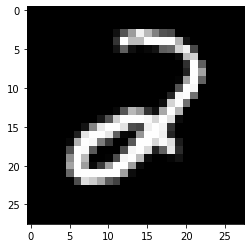

In [8]:
image

## **데이터 전처리**

### **tensor 변환**
- 입력으로 공급할 수 있도록 텐서 형태로 변환

In [9]:
def image_to_tensor(image):
  # 흑백 이미지로 변환
  gray_image = transforms.functional.to_grayscale(image)
  # 이미지 크기 조정(모델 학습 시에 활용된 (28, 28) 크기)
  resized_image = transforms.functional.resize(gray_image, (28, 28))
  # img array -> torch.tensor
  input_image_tensor = transforms.functional.to_tensor(resized_image)
  # 이미지 정규화
  input_image_tensor_norm = transforms.functional.normalize(input_image_tensor, (0.1302,), (0.3069,))

  return input_image_tensor_norm

In [10]:
input_tensor = image_to_tensor(image)

## **모델 추론**

### **추론**

In [11]:
def run_model(input_tensor):
  model_input = input_tensor.unsqueeze(0) # 입력: torch.tensor

  with torch.no_grad():
    model_output = model(model_input)[0] # 각 클래스(0 ~ 9)에 속할 확률을 계산

  model_prediction = model_output.detach().numpy().argmax() # 가장 확률이 높은 클래스 1개를 선택

  return model_prediction

In [12]:
output = run_model(input_tensor)

print(output)
print(type(output))

2
<class 'numpy.int64'>


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


### **디버깅 함수**
- 원시 예측 확률 등의 지표 확인 가능

In [13]:
def debug_model(input_tensor):
  model_input = input_tensor.unsqueeze(0)

  with torch.no_grad():
    model_output = model(model_input)[0]

  model_prediction = model_output.detach().numpy()

  return np.exp(model_prediction) # log_softmax() 값을 원복(softmax()의 출력값과 동일)

In [14]:
print(debug_model(input_tensor))

[1.6447244e-04 8.4695084e-06 9.9906117e-01 1.7424113e-04 2.5066842e-05
 4.6525201e-07 4.8991798e-05 1.4072977e-05 4.9448595e-04 8.6919654e-06]


- 세 번째에 해당하는 확률이 가장 높음
> class 2에 해당

## **후처리**
- 모델 예측을 다른 애플리케이션에서 사용할 수 있도록 하는 과정

> 여기서는 모델이 예측한 숫자를 정수 타입에서 문자열 타입으로만 변환해 보자.

In [15]:
def post_process(output):
  return str(output)

In [16]:
final_output = post_process(output)

print(final_output)
print(type(final_output))

2
<class 'str'>
